<a href="https://colab.research.google.com/github/ipietri/w266_Final_Project/blob/master/notebooks/RtGender-Notebooks/Annotations_BoW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RtGender- Annotations - BoW Neural Net

In this notebook we build the baseline models for the RtGender dataset. 

Characteristics of the models:
- Neural Bag of Words architecture
- A single dense layer with dropout
- Use Glove embeddings (dim=300) without fine tuning them
- Maximum sequence length is 100




In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  path = r'/content/drive/MyDrive/w266'
except ModuleNotFoundError:
  path = r'data'

Mounted at /content/drive


## Package imports

In [ ]:
%%capture
!pip install keras_tuner

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import seaborn as sns

from collections import Counter

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
import tensorflow.keras.backend as K
# for hyperparameter tunning
import keras_tuner as kt
from keras_tuner import HyperModel
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


# import sklearn to calculate the metrics
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
import os
os.getcwd()

'/content'

# Load
Load training, development and test datasets. See RtGender Split and Save notebook to see approach. 

In [ ]:
# Load post data
# posts_train = pd.read_parquet('../../data/RtGender/posts_train.parquet.gzip')
# posts_test = pd.read_parquet('../../data/RtGender/posts_tests.parquet.gzip')
# posts_dev= pd.read_parquet('../../data/RtGender/posts_dev.parquet.gzip')

# # # response data 
# # responses_train = pd.read_parquet('RtGender/datasets/responses_train.parquet')
# # #responses_test = pd.read_parquet('RtGender/datasets/responses_test.parquet')
# # responses_dev = pd.read_parquet('RtGender/datasets/responses_dev.parquet')

# # annotations data
# annotations = pd.read_parquet('../../data/RtGender/annotations.parquet.gzip')

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/w266/annotations_train.csv') #train_oversampled
dev_df = pd.read_csv('/content/drive/MyDrive/w266/annotations_dev.csv')

print('train_shape: ',train_df.shape)
print('dev_shape: ',dev_df.shape)

train_shape:  (10746, 9)
dev_shape:  (2303, 9)


In [ ]:
nan_values = dev_df[dev_df.isna().any(axis=1)] 
print(nan_values)

# return without missing values in response_text
dev_df.dropna(subset = ["response_text"], inplace=True)

      Unnamed: 0         source op_gender  ...   relevance label labels_4
830         2576  facebook_wiki         M  ...  Irrelevant     1        1
1664        2722  facebook_wiki         W  ...  Irrelevant     1        1

[2 rows x 9 columns]


In [ ]:
X_train = train_df['response_text']
y_train = train_df['labels_4']
X_dev = dev_df['response_text']
y_dev = dev_df['labels_4']

In [ ]:
y_train

0        2
1        2
2        3
3        2
4        3
        ..
10741    2
10742    0
10743    3
10744    1
10745    2
Name: labels_4, Length: 10746, dtype: int64

## Load GloVe 

In [ ]:
# load pre-trained word embeddings. In this case Glove
# This is commented out to avoid downloading it again
!wget http://nlp.stanford.edu/data/glove.6B.zip -P ~/data/

# # unzip the file
# # commented out for the same reason above
!unzip ~/data/glove.6B.zip -d ~/data/

--2021-10-22 21:07:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-22 21:07:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-22 21:07:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/root/data/glove.6B.zi

In [ ]:
# path to glove file- will use the embeddings with dimension = 300
glove_file ="/root/data/glove.6B.300d.txt"

# embedding layer 
embeddings_index = {}
f = open(os.path.join(glove_file))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Preprocess

In [ ]:
# tokenize data and return embeddings matrix 
max_tokens = 10000
# consider this maximum number of words
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_tokens)

#x_train, x_dev, embedding_matrix = tokenize_Xtrain_and_Xdev(X_train, X_dev)

# one-hot encodign and reshape labels
print("-"*60)

train_labels = to_categorical(np.asarray(y_train))
dev_labels = to_categorical(np.asarray(y_dev))

print('Shape of train label tensor:', train_labels.shape)
print('Shape of dev label tensor:', dev_labels.shape)

------------------------------------------------------------
Shape of train label tensor: (10746, 4)
Shape of dev label tensor: (2301, 4)


## Preprocess & Embeddings matrix

In [ ]:
x_train = X_train 
x_dev = X_dev
 # note the length of the training index
train_idx = len(x_train)
#combine train and dev data and then tokenize
texts = x_train.append(x_dev)

tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Train + Dev %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=max_sequence_length)
print('Shape of data tensor:', data.shape)

x_train = data[:train_idx]
x_dev = data[train_idx:]
print('Shape of train data tensor:', x_train.shape)
print('Shape of dev data tensor:', x_dev.shape)
print("-"*60)

# print top 5 most and least common tokens
print("top 5 most common tokens: ", sorted(word_index, key=word_index.get, reverse=True)[-5:])
print("top 5 least common tokens: ", sorted(word_index, key=word_index.get, reverse=True)[:5])
print("-"*60)

# build embedding matrix to use it in the model
dimensions_emb = 300

# zero position is zero by default in keras
embedding_matrix = np.zeros((len(word_index) + 1, dimensions_emb)) 

total_tokens = len(word_index) + 1
with_embedding = []
without_embedding = []

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        with_embedding.append(word)
    else:
        without_embedding.append(word)

print(f'Number of words with embeddings found: {len(with_embedding)}')
print(f'Number of words with embeddings NOT found: {len(without_embedding)}')        



Train + Dev 20145 unique tokens.
Shape of data tensor: (13047, 100)
Shape of train data tensor: (10746, 100)
Shape of dev data tensor: (2301, 100)
------------------------------------------------------------
top 5 most common tokens:  ['and', 'you', 'i', 'to', 'the']
top 5 least common tokens:  ['interupt', 'grandeur', 'inadequate', 'woefully', 'robisz']
------------------------------------------------------------
Number of words with embeddings found: 16754
Number of words with embeddings NOT found: 3391


## Best Model

In [ ]:
def multiclass_model_builder(hp):
    model = tf.keras.Sequential()
    model.add(embedding_layer) 
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) #avg

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10 and 100
    hp_units = hp.Int('units', min_value=10, max_value=100, step=10)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune dropout layer 
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(4, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy', 
                metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])

    return model

In [ ]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)

tuner = kt.Hyperband(multiclass_model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=100,
                     factor=4,
                     directory='my_dir',
                     project_name='intro_to_kt2')

tuner.search(x_train, train_labels, validation_data=(x_dev, dev_labels),
             epochs=1)



In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the best drop-out rate is {best_hps.get('dropout')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 90 and the optimal learning rate for the optimizer
is 0.01 and the best drop-out rate is 0.3.



In [ ]:
# create a model off the best model
model = tuner.hypermodel.build(best_hps)
model.save(os.path.join(path,'annotations_sentiment_bow_neural_model'))

# fit model 
history = model.fit(x_train, train_labels,
                    validation_data=(x_dev, dev_labels),
                    epochs=50, verbose=0)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/w266/annotations_sentiment_bow_neural_model/assets


## Metrics

In [ ]:
def binary_loss_accuracy_plots(training_history):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # summarize history for accuracy
    ax1.plot(training_history.history['binary_accuracy'])
    ax1.plot(training_history.history['val_binary_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc='upper left')

    # summarize history for loss
    ax2.plot(training_history.history['loss'])
    ax2.plot(training_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'dev'], loc='upper left')

    plt.show()
    
def multiclass_loss_accuracy_plots(training_history):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # summarize history for accuracy
    ax1.plot(training_history.history['categorical_accuracy'])
    ax1.plot(training_history.history['val_categorical_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc='upper left')

    # summarize history for loss
    ax2.plot(training_history.history['loss'])
    ax2.plot(training_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'dev'], loc='upper left')

    plt.show()

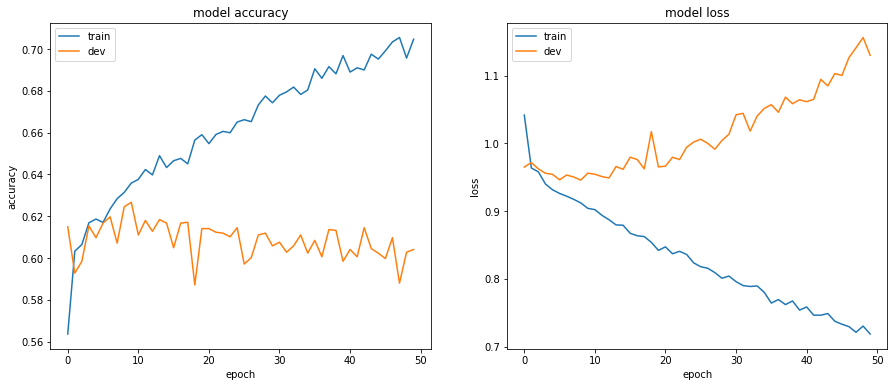

In [ ]:
from sklearn.metrics import confusion_matrix
multiclass_loss_accuracy_plots(history)
y_pred = model.predict(x_dev) #predict


In [ ]:
def confusion_matrix(x_dev, original_dev_labels, class_labels):

    # identify the correct class
    max_class_idx = np.argmax(y_pred, axis = 1)
    
    # Create a confusion matrix
    cm = tf.math.confusion_matrix(original_dev_labels, max_class_idx)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    sns.heatmap(
        cm, annot=True,
        xticklabels=class_labels,
        yticklabels=class_labels,
        fmt='.2%', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # print classification report
    print(metrics.classification_report(original_dev_labels, max_class_idx))
    # print global weighted f-1 score
    f1 = metrics.f1_score(original_dev_labels, max_class_idx, pos_label=1, average='weighted')*100
    print(f"Weighted f1-score: %.2f%%" %f1)


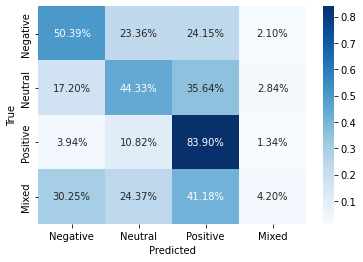

              precision    recall  f1-score   support

           0       0.47      0.50      0.49       381
           1       0.48      0.44      0.46       564
           2       0.71      0.84      0.77      1118
           3       0.20      0.04      0.07       238

    accuracy                           0.60      2301
   macro avg       0.47      0.46      0.45      2301
weighted avg       0.56      0.60      0.57      2301

Weighted f1-score: 57.39%


In [ ]:
sentiment_labels = ["Negative", "Neutral", "Positive", "Mixed"] #{'Positive': 2, 'Mixed': 3, 'Neutral': 1, 'Negative':0}
confusion_matrix(y_pred, y_dev, sentiment_labels)

# Optimal Model Iterated

In [ ]:
iterations = 5

In [ ]:
from sklearn.metrics import classification_report
accuracy_list = []
weighted_f1_score_list = []
macro_f1_score_list = []
negative_f1_score = []
neutral_f1_score = []
mixed_f1_score = []
positive_f1_score = []

for i in range(iterations):
  try:
    del history
    del y_pred
    del cr
  except: pass


  history = model.fit(x_train, train_labels,
                      validation_data=(x_dev, dev_labels),
                      epochs=50, verbose=0)
  y_pred = model.predict(x_dev) #predict

  # metrics append to appropriate lists
  predictions = y_pred.argmax(1)
  cr = metrics.classification_report(y_dev, predictions, digits=3, output_dict=True)
  
  accuracy_list.append(cr.get('accuracy'))
  weighted_f1_score_list.append(cr.get('weighted avg').get("f1-score"))
  macro_f1_score_list.append(cr.get("macro avg").get("f1-score"))

  negative_f1_score.append(cr.get('0').get("f1-score"))
  neutral_f1_score.append(cr.get('1').get("f1-score"))
  positive_f1_score.append(cr.get('2').get("f1-score"))
  mixed_f1_score.append(cr.get('3').get("f1-score"))

  print(f'---------------------------Iteration {i+1} Complete---------------------------\n')


---------------------------Iteration 1 Complete---------------------------

---------------------------Iteration 2 Complete---------------------------

---------------------------Iteration 3 Complete---------------------------

---------------------------Iteration 4 Complete---------------------------

---------------------------Iteration 5 Complete---------------------------



In [ ]:
import statistics

print("%15s %s (%s)" % ("","Mean", "StDev"))

print("-"*29)
print("Macro Scores")
print("-"*29)

print(f"%15s %s (%s)" %("Accuracy",
    round(statistics.mean(accuracy_list),3),
    round(statistics.stdev(accuracy_list),3)))
print(f"%15s %5s (%s)" %("Macro F1",
    round(statistics.mean(macro_f1_score_list),3),
    round(statistics.stdev(macro_f1_score_list),3)))
print(f"%15s %5s (%s)" %("Weighted F1",
    round(statistics.mean(weighted_f1_score_list),3),
    round(statistics.stdev(weighted_f1_score_list),3)))

print("-"*29)
print("Class Scores")
print("-"*29)

print(f"%15s %s (%s)" %("Positive",
    round(statistics.mean(positive_f1_score),3),
    round(statistics.stdev(positive_f1_score),3)))
print(f"%15s %5s (%s)" %("Neutral",
    round(statistics.mean(neutral_f1_score),3),
    round(statistics.stdev(neutral_f1_score),3)))
print(f"%15s %5s (%s)" %("Negative",
    round(statistics.mean(negative_f1_score),3),
    round(statistics.stdev(negative_f1_score),3)))
print(f"%15s %5s (%s)" %("Mixed",
    round(statistics.mean(mixed_f1_score),3),
    round(statistics.stdev(mixed_f1_score),3)))

                Mean (StDev)
-----------------------------
Macro Scores
-----------------------------
       Accuracy 0.572 (0.003)
       Macro F1 0.431 (0.005)
    Weighted F1 0.553 (0.004)
-----------------------------
Class Scores
-----------------------------
       Positive 0.743 (0.006)
        Neutral 0.446 (0.012)
       Negative  0.43 (0.014)
          Mixed 0.106 (0.016)


# Parking Lot
the rest of this notebook required more RAM and GPUs to run. The Posts op gender ran on Colab Pro but Responses did not.

In [ ]:
#Load model
tf.keras.models.load_model(
    os.path.join(path,'annotations_sentiment_bow_neural_model'), custom_objects=None, compile=True, options=None)


OSError: ignored

## Posts - Op Gender

In [ ]:
X_train = posts_train['post_text']
y_train = posts_train['op_gender'].map(gender_binary_mappings)
X_dev = posts_dev['post_text']
y_dev = posts_dev['op_gender'].map(gender_binary_mappings)

### Tokenize & Create Embeddings Layer

In [ ]:
# tokenize data and return embeddings matrix 
max_tokens = 10000
# consider this maximum number of words
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_tokens)

x_train, x_dev, embedding_matrix = tokenize_Xtrain_and_Xdev(X_train, X_dev)

# one-hot encodign and reshape labels
print("-"*60)

train_labels = to_categorical(np.asarray(y_train))
dev_labels = to_categorical(np.asarray(y_dev))

print('Shape of train label tensor:', train_labels.shape)
print('Shape of dev label tensor:', dev_labels.shape)

Train + Dev 559520 unique tokens.
Shape of data tensor: (2883387, 100)
Shape of train data tensor: (2137983, 100)
Shape of dev data tensor: (745404, 100)
------------------------------------------------------------
top 5 most common tokens:  ['of', 'a', 'and', 'to', 'the']
top 5 least common tokens:  ['digikey', 'mu6300', 'aliant', 'metrotown', 'beamdog']
------------------------------------------------------------
Number of words with embeddings found: 146683
Number of words with embeddings NOT found: 412837
------------------------------------------------------------
Shape of train label tensor: (2137983, 2)
Shape of dev label tensor: (745404, 2)


In [ ]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)

### Run Model - Hypertune

In [ ]:
def post_op_binary_model_builder(hp):
    model = tf.keras.Sequential()
    model.add(embedding_layer) 
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) #avg

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10 and 25
    hp_units = hp.Int('units', min_value=10, max_value=25, step=5)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune dropout layer 
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, default=0.0, step=0.1)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(2, activation='sigmoid'))

    # Tune the learning rate for the optimizer
  
    model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['binary_accuracy', 'binary_crossentropy'])

    return model

In [ ]:
tuner = kt.Hyperband(post_op_binary_model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='my_dir',
                     project_name='op_gender')

tuner.search(x_train, train_labels, validation_data=(x_dev, dev_labels),
             epochs=1, verbose=0)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
model = tuner.hypermodel.build(best_hps)


INFO:tensorflow:Reloading Oracle from existing project my_dir/op_gender/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/op_gender/tuner0.json


In [ ]:
model.save('RtGender/models/posts_op_gender_baseline_model')

# fit model 
history = model.fit(x_train, train_labels,
                    validation_data=(x_dev, dev_labels),
                    epochs=5, verbose=0)

### Metrics 

In [ ]:
binary_loss_accuracy_plots(history)
y_pred = model.predict(x_dev) #predict
confusion_matrix(x_dev, y_dev, gender_labels)

## Annotations: Op Gender Model
[Source](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)


In [ ]:
#Annotations data split train: 70%, dev: 15%, test: 15%

X = annotations['post_text']
y = annotations['op_gender'].map(gender_binary_mappings)

#1st split: 70 train /30 test
ann_train, ann_test, ann_train_op_gender, ann_test_op_gender = train_test_split(
X, y, test_size = .3, random_state = 1222, stratify = y)

#2nd split: test data 50/50 into test/dev
ann_test, ann_dev, ann_test_op_gender, ann_dev_op_gender = train_test_split(
ann_test, ann_test_op_gender, test_size = .5, random_state = 1222, stratify = ann_test_op_gender)

## Prepare the data for modeling and create Embeddings matrix

In [ ]:
# tokenize data and return embeddings matrix 
max_tokens = 10000
# consider this maximum number of words
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_tokens)

x_train, x_dev, embedding_matrix = tokenize_Xtrain_and_Xdev(ann_train, ann_dev)

# one-hot encodign and reshape labels
print("-"*60)

train_labels = to_categorical(np.asarray(ann_train_op_gender))
dev_labels = to_categorical(np.asarray(ann_dev_op_gender))

print('Shape of train label tensor:', train_labels.shape)
print('Shape of dev label tensor:', dev_labels.shape)

Train + Dev 21901 unique tokens.
Shape of data tensor: (13049, 100)
Shape of train data tensor: (10746, 100)
Shape of dev data tensor: (2303, 100)
------------------------------------------------------------
top 5 most common tokens:  ['i', 'and', 'a', 'to', 'the']
top 5 least common tokens:  ["hagel's", 'approves', 'disasterassistance', 'tropical', 'suffered']
------------------------------------------------------------
Number of words with embeddings found: 17158
Number of words with embeddings NOT found: 4743
------------------------------------------------------------
Shape of train label tensor: (10746, 2)
Shape of dev label tensor: (2303, 2)


## Create Model

In [ ]:
# Define the model
from keras.layers import Embedding

# delete model if exists
try:
    del ANN_OP_GENDER
except:
    pass

# create embedding layer
# input_lenght: Keras' embedding layer expects a specific input length. Padding is needed here. The vectorizer
# defined above takes care of the padding
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)


# simple sequential model
ANN_OP_GENDER = tf.keras.Sequential()
# include the embedding layer
ANN_OP_GENDER.add(embedding_layer)
# average embedding vectors
ANN_OP_GENDER.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) 
# hidden layer with rectified linear activation function (relu)
ANN_OP_GENDER.add(Dense(100, activation='relu'))  
# dropout layer for regularization
ANN_OP_GENDER.add(Dropout(0.2))
# output layer with 2 classes classification
ANN_OP_GENDER.add(Dense(2, activation='softmax'))

2021-09-30 02:24:47.584035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-09-30 02:24:47.584101: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-30 02:24:47.584136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (w266-teslat4): /proc/driver/nvidia/version does not exist
2021-09-30 02:24:47.584730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# compile the model
# categorical_crossentropy: loss function appropiate for multi-class single label classification
ANN_OP_GENDER.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=['binary_accuracy', 'binary_crossentropy'])

# summary of the model's architecture
ANN_OP_GENDER.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          6570600   
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 6,600,902
Trainable params: 30,302
Non-trainable params: 6,570,600
_________________________________________________________________


In [ ]:
# train the model and store the training history
training_history = ANN_OP_GENDER.fit(x_train, train_labels,
                                     validation_data=(x_dev, dev_labels),
                                     epochs=50, verbose=0)

2021-09-30 02:24:53.443771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


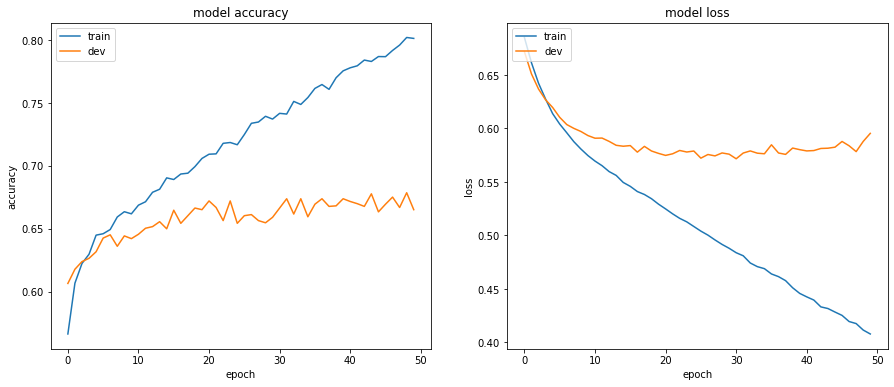

In [ ]:
binary_loss_accuracy_plots(training_history)

This model is clearly overfitting. 

## Tune
[source](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [ ]:
def binary_model_builder(hp):
    model = tf.keras.Sequential()
    model.add(embedding_layer) 
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) #avg

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10 and 100
    hp_units = hp.Int('units', min_value=10, max_value=100, step=10)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune dropout layer 
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(2, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy', 
                metrics=['binary_accuracy', 'binary_crossentropy'])

    return model

In [ ]:
tuner = kt.Hyperband(binary_model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt2/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt2/tuner0.json


In [ ]:
tuner.search(x_train, train_labels, validation_data=(x_dev, dev_labels),
             epochs=50, verbose=0)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 30 and the optimal learning rate for the optimizer
is 0.0001.



Run the model with the optimal hyperparameters

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels,
                    validation_data=(x_dev, dev_labels),
                    epochs=50, verbose=0)

Review the performance of the selected model in the test data:

## Metrics

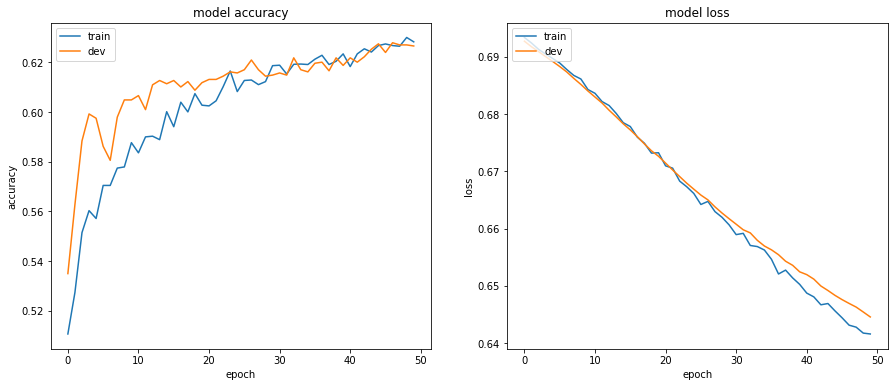

In [ ]:
binary_loss_accuracy_plots(history)

Still overfitting. 

### Confusion Matrix

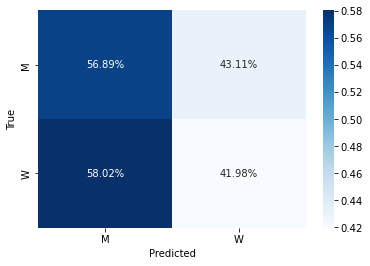

              precision    recall  f1-score   support

           0       0.50      0.57      0.53      1169
           1       0.49      0.42      0.45      1134

    accuracy                           0.50      2303
   macro avg       0.49      0.49      0.49      2303
weighted avg       0.49      0.50      0.49      2303

Weighted f1-score: 49.27%


In [ ]:
y_pred = model.predict(x_dev) #predict
confusion_matrix(x_dev, ann_dev_op_gender, gender_labels)

In [ ]:
#@title
#Annotations data split train: 70%, dev: 15%, test: 15%

X = annotations['response_text']
y = annotations['sentiment'].map(sentiment_mappings)

#1st split: 70 train /30 test
X_train, X_dev, y_train, y_dev = train_test_split(
X, y, test_size = .3, random_state = 1222, stratify = y)

#2nd split: test data 50/50 into test/dev
X_test, X_dev, y_test, y_dev = train_test_split(
X_dev, y_dev, test_size = .5, random_state = 1222, stratify = y_dev)

In [ ]:
def tokenize_Xtrain_and_Xdev(x_train, x_dev):
    '''Combine tokenize and split back the X_train and 
    X_dev or X_test datasets. Then create an embedding matrix.'''

    # note the length of the training index
    train_idx = len(x_train)
    #combine train and dev data and then tokenize
    texts = x_train.append(x_dev)

    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Train + Dev %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=max_sequence_length)
    print('Shape of data tensor:', data.shape)
    
    x_train = data[:train_idx]
    x_dev = data[train_idx:]

    print('Shape of train data tensor:', x_train.shape)
    print('Shape of dev data tensor:', x_dev.shape)
    print("-"*60)
    
    # print top 5 most and least common tokens
    print("top 5 most common tokens: ", sorted(word_index, key=word_index.get, reverse=True)[-5:])
    print("top 5 least common tokens: ", sorted(word_index, key=word_index.get, reverse=True)[:5])
    print("-"*60)

    
    # build embedding matrix to use it in the model
    # dimensions_emb = 300

    # # zero position is zero by default in keras
    # embedding_matrix = np.zeros((len(word_index) + 1, dimensions_emb)) 

    # total_tokens = len(word_index) + 1
    # with_embedding = []
    # without_embedding = []

    # for word, i in word_index.items():
    #     embedding_vector = embeddings_index.get(word)
    #     if embedding_vector is not None:
    #         # words not found in embedding index will be all-zeros.
    #         embedding_matrix[i] = embedding_vector
    #         with_embedding.append(word)
    #     else:
    #         without_embedding.append(word)

    # print(f'Number of words with embeddings found: {len(with_embedding)}')
    # print(f'Number of words with embeddings NOT found: {len(without_embedding)}')        

    
    # return x_train, x_dev, embedding_matrix
